# Part 2.2 Entropy Fuzzy Support Vector Machine
**과목명:  응용데이터애널리틱스 (Applied Data Analytics)** \\
**학수번호:  INE4108** \\
**교강사:  송재욱 교수 (산업공학과)** \\
 \\
***

### 2.2.0. Environmental Set-up & Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

In [ ]:
data_ = pd.read_csv('./ADX/Data_CreditCard/creditcard.csv', encoding ='cp949', index_col = 0)
columns_ = data_.columns

In [ ]:
data_.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
190368,128803.0,-2.272473,2.935226,-4.871394,2.419012,-1.513022,-0.480625,-2.126136,1.883507,-1.297262,-5.487425,2.969240,-3.055405,-0.316544,-7.862809,-2.202800,-1.932316,-2.284748,0.324787,-0.183181,-0.031085,0.718504,0.893850,-0.031632,0.322913,-0.058406,-0.411649,0.573803,0.176067,175.90,1
9179,13126.0,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,-3.429304,-11.561950,10.446847,-15.479052,0.734442,-13.883779,0.821440,-11.911483,-18.103004,-6.837835,3.126929,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,1.00,1
42700,41204.0,-8.440284,6.147653,-11.683706,6.702780,-8.155839,-3.716264,-12.407313,5.626571,-6.232161,-13.386683,7.605559,-13.351815,0.827050,-14.979477,1.532813,-11.771497,-20.299217,-7.609110,3.809136,0.520732,2.192855,-0.282597,0.008068,0.403858,-0.018788,0.522722,0.792691,0.067790,30.26,1
239501,150139.0,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,-0.448794,-2.562602,0.243483,-1.181669,0.004373,-2.302596,-4.446192,-1.710463,0.982729,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,237.26,1
154286,101051.0,-1.465316,-1.093377,-0.059768,1.064785,11.095089,-5.430971,-9.378025,-0.446456,1.992110,1.785922,1.368585,-1.471697,-0.724759,3.442422,-0.957403,-1.626129,1.418215,-1.417917,-1.651766,-1.457610,1.160623,-1.259697,-15.981649,-0.883670,-3.536716,-0.592965,0.675525,0.424849,0.92,1


### 2.2.1. Functions to be used

In [ ]:
def Kernel_(x, y, params = 0, type_ = 'default') :
    if type_ == 'rbf' :
      Kernel = np.exp(- (np.sum(x **2, axis = 1).reshape(-1,1) + np.sum(y **2, axis = 1).reshape(1,-1) - 2 * x @ y.T)* params)
      return Kernel
    elif type_ == 'default' :
      Kernel = np.dot(x, y.T)
      return Kernel

def Minmax_(X) :
    return (X - X.min(axis = 0)) / (X.max(axis= 0) - X.min(axis = 0)), X.max(axis =0) , X.min(axis =0)

def Standar_(X) :
    return (X - X.mean(axis =0)) / X.std(axis = 0), X.mean(axis =0), X.std(axis = 0)

def Convolution(pred, real) :
    pred = np.array(pred)
    y = np.array(real)
    TP = np.sum((pred == 1) & (y == 1))
    FP = np.sum((pred == 1) & (y != 1))
    FN = np.sum((pred != 1) & (y == 1))
    TN = np.sum((pred != 1) & (y != 1))
    return TP, FP, FN, TN

############## Accuracy is newly included!
def acc_precision_recall(X) :
  TP,FP,FN,TN = X
  return (TP + TN) / (TP + FP + FN + TN), TP / (TP + FP), TP / (TP + FN)

### 2.2.2. Linear Kernel Support Vector Machine

In [ ]:
###### Standardization Scaler + Linear

# Hyperparameter
C = 10 

#Initializing values and computing H. Note the 1. to force to float type
X = Standar_(np.array(data_[columns_[:-1]]))[0]
y = np.array(data_[columns_[-1]])* 1.

y = y.reshape(-1,1) 
m,n = X.shape

#Kernel 관련 정의 numpy array 형식으로 생성
H = Kernel_(X, X) * 1.
H *= y@y.T
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

w = ((y * alphas).T @ X).reshape(-1,1)
S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S], type_ = 'default')* y * alphas , axis = 0).reshape(-1,1)

print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
print('')
print('w = ', w.flatten())
print('')
print('b = ', np.mean(b))
print('')
print("support vector : ", np.array(range(m))[S])

     pcost       dcost       gap    pres   dres
 0: -5.8129e+02 -1.0298e+05  4e+05  1e+00  6e-13
 1: -4.2201e+02 -5.1005e+04  1e+05  3e-01  6e-13
 2: -2.6726e+02 -2.0455e+04  4e+04  9e-02  4e-13
 3: -1.8589e+02 -1.0262e+04  2e+04  4e-02  3e-13
 4: -9.6012e+01 -5.7119e+03  8e+03  1e-02  3e-13
 5: -8.7623e+01 -2.4313e+03  3e+03  4e-03  2e-13
 6: -1.3650e+02 -1.2150e+03  1e+03  1e-03  2e-13
 7: -1.7550e+02 -6.5484e+02  5e+02  3e-04  2e-13
 8: -1.9086e+02 -5.3416e+02  3e+02  1e-04  2e-13
 9: -2.0543e+02 -4.3445e+02  2e+02  5e-05  2e-13
10: -2.1462e+02 -4.0309e+02  2e+02  3e-05  2e-13
11: -2.2073e+02 -3.7532e+02  2e+02  2e-05  2e-13
12: -2.3983e+02 -3.3847e+02  1e+02  5e-06  2e-13
13: -2.4876e+02 -3.1464e+02  7e+01  3e-06  2e-13
14: -2.4776e+02 -3.1241e+02  6e+01  2e-06  2e-13
15: -2.5088e+02 -3.0203e+02  5e+01  2e-06  2e-13
16: -2.5455e+02 -2.9130e+02  4e+01  9e-07  3e-13
17: -2.5610e+02 -2.8591e+02  3e+01  6e-07  2e-13
18: -2.6030e+02 -2.7701e+02  2e+01  1e-07  3e-13
19: -2.6374e+02 -2.71

In [ ]:
# Solution
pred_sol = np.sign(np.sum(Kernel_(X, X  ,type_ = 'default')* y * alphas , axis = 0).reshape(-1,1) + b[0])
#accuracy(Convolution(pred_sol,y))
acc_precision_recall(Convolution(pred_sol,y))

(0.99, 0.9891304347826086, 0.91)

### 2.2.3. Gaussian (RBF) Kernel Support Vector Machines


In [ ]:
###### Standardization Scaler + RBF

# Hyperparameter
C = 10
Gamma = 2

#Initializing values and computing H. Note the 1. to force to float type
X = Standar_(np.array(data_[columns_[:-1]]))[0]
y = np.array(data_[columns_[-1]])* 1.

y = y.reshape(-1,1) 
m,n = X.shape

#Kernel 관련 정의 numpy array 형식으로 생성
H = Kernel_(X,  X  , params = Gamma, type_ = 'rbf')* 1.
H *= y@y.T 
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#Results
S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S]  , params = 2, type_ = 'rbf')* y * alphas , axis = 0).reshape(-1,1)
print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
print('')
print('b = ', b[0])
print('')
print("support vector : ", np.array(range(m))[S])

     pcost       dcost       gap    pres   dres
 0:  1.1233e+03 -2.1902e+04  2e+04  5e-13  5e-15
 1:  4.0674e+02 -3.1858e+03  4e+03  2e-13  5e-15
 2: -1.3134e+02 -4.7529e+02  3e+02  5e-13  1e-15
 3: -1.7599e+02 -2.0145e+02  3e+01  3e-13  3e-16
 4: -1.7673e+02 -1.7721e+02  5e-01  8e-14  8e-17
 5: -1.7674e+02 -1.7678e+02  4e-02  3e-13  7e-17
 6: -1.7674e+02 -1.7674e+02  2e-03  3e-13  6e-17
 7: -1.7674e+02 -1.7674e+02  4e-05  3e-14  7e-17
Optimal solution found.
Alphas =  [1.79257312e+00 1.79257312e+00 1.79257311e+00 1.79257312e+00
 1.79257312e+00 1.79257312e+00 1.79257312e+00 1.79257312e+00
 1.79257312e+00 1.79256632e+00 1.79257312e+00 1.79257312e+00
 1.79353230e+00 1.17711994e+00 1.79257312e+00 1.79257312e+00
 1.79257312e+00 1.79257312e+00 1.79257312e+00 1.79257312e+00
 1.74407303e+00 1.79256950e+00 1.79257312e+00 1.79257312e+00
 1.79257312e+00 1.79257312e+00 1.74407303e+00 1.79257276e+00
 1.79257312e+00 1.79258873e+00 1.48827655e+00 1.79304876e+00
 1.79301497e+00 1.79257314e+00 1.79256

In [ ]:
# Solution
pred_sol = np.sign(np.sum(Kernel_(X, X  , params = 2, type_ = 'rbf')* y * alphas , axis = 0).reshape(-1,1) + b[0])
acc_precision_recall(Convolution(pred_sol,y))

(1.0, 1.0, 1.0)

### 2.2.4. Entropy-based Fuzzy Membership & $s_i$ for EFSVM

### You should use the following hyperparameters to compute $s_i$ for EFSVM

Hyperparameter: $k = 7$, $m = 10$, $\beta$ = 1/18 $\in(0, \frac{1}{m-1}]$

In [ ]:
# You could use the following function to calculate the entropy
from scipy.stats import entropy

# You can use the following function to calculate the Euclidean distance (distance.cdist)
from scipy.spatial import distance

In [ ]:
# Hyperparameter
C = 10
Gamma = 2 
k = 7 # Number of Nearest Neighbor
m = 10
beta = 1/18

In [ ]:
#################################################################################
# TODO: Generate s_i !!!!!
# 1. Euclidean distance 계산
# 2. Negative class에 대한 Entropy 계산 (k=7 사용)
# 3. m = 10 / beta = 1/8을 사용하여 Entropy-based Fuzzy Membership 계산
# 4. Positive와 Negative class 모두에 대해 si 부여
#################################################################################

df = data_.copy()

# 1. Euclidean distance 계산
#distance = distance.cdist(data_, data_, metric='euclidean')
#dist =  pd.DataFrame(distance.cdist(data_, data_, metric='euclidean'), index = data_.index)
dist = distance.cdist(data_, data_, metric='euclidean')
#엔트로피 계산부분
Entropys = list()
major_index = df['Class'] == -1 #덜 중요한 데이터
#major = df[major_]
for i in range(0,len(df)):
    num_plus = 0
    #a = dist[major]
    a = np.array(dist[i])
    neighbors_index = a.argsort()[1:k+1] #자기자신은 0이므로 가장 앞에 있을것. 즉 제외
    for j in neighbors_index:
        if df.iloc[j]['Class'] == 1: #중요도 높은 것, 즉 안 갚은 이웃의 수가 num_plus
            num_plus +=1
    p_p = num_plus/k
    p_n = 1.0 - p_p
    if(p_p == 0  or p_n == 0):
        entropy = 0.0
    else:
        entropy = (- p_p)*np.log(p_p) - p_n*np.log(p_n) #엔트로피 계산
    Entropys.append(entropy)
df['Entropy'] = Entropys
#N = len(major_index)


#Subset 생성부분
up = df['Entropy'].argmax()
low = df['Entropy'].argmin()
Hmax = df.iloc[up]['Entropy']
Hmin = df.iloc[low]['Entropy']

FML = list()
for i in range(0,len(df)):
    if df.iloc[i]['Class'] == 1:
        FML.append(1)
    else:
        for L in range(1,m+1): 
            thrUp = Hmin + L*(Hmax - Hmin)/(m-1)
            thrLow = Hmin + (L-1.0)*(Hmax - Hmin)/(m-1)
            if df.iloc[i]['Entropy']>=thrLow and df.iloc[i]['Entropy'] < thrUp:
                FML.append(1.0 - beta*(L)) #Subset에 해당하는 data들의 index값이 들어감

df['FM'] = FML

In [ ]:
df['FM'].value_counts()

0.944444    503
0.666667    272
1.000000    100
0.555556     90
0.444444     35
Name: FM, dtype: int64

In [ ]:
len(df['FM'])

1000

### 2.2.5. Linear Kernel Entropy Fuzzy Support Vector Machine (Standard Scaler)

In [ ]:
#################################################################################
# TODO: 위 Linear Kernel SVM을 사용하여 Linear Kernel EFSVM 구현
#################################################################################


###### Standardization Scaler + Linear

# Hyperparameter
C = 10 

#Initializing values and computing H. Note the 1. to force to float type
X = Standar_(np.array(data_[columns_[:-1]]))[0]
y = np.array(data_[columns_[-1]])* 1.

y = y.reshape(-1,1) 
m,n = X.shape

#Kernel 관련 정의 numpy array 형식으로 생성
H = Kernel_(X, X) * 1.
H *= y@y.T
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m)* df['FM'] * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

w = ((y * alphas).T @ X).reshape(-1,1)
S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S], type_ = 'default')* y * alphas , axis = 0).reshape(-1,1)

print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
print('')
print('w = ', w.flatten())
print('')
print('b = ', np.mean(b))
print('')
print("support vector : ", np.array(range(m))[S])

     pcost       dcost       gap    pres   dres
 0: -5.2993e+02 -9.3736e+04  4e+05  2e+00  6e-13
 1: -4.0025e+02 -4.9121e+04  1e+05  3e-01  6e-13
 2: -2.5739e+02 -2.0027e+04  3e+04  1e-01  4e-13
 3: -1.7682e+02 -1.0034e+04  2e+04  4e-02  2e-13
 4: -1.0540e+02 -6.1754e+03  9e+03  2e-02  2e-13
 5: -8.9757e+01 -3.0061e+03  4e+03  7e-03  2e-13
 6: -1.2898e+02 -1.3439e+03  1e+03  2e-03  3e-13
 7: -1.7338e+02 -5.5613e+02  4e+02  2e-05  2e-13
 8: -1.9038e+02 -4.3903e+02  2e+02  1e-05  2e-13
 9: -1.9888e+02 -4.1797e+02  2e+02  7e-06  2e-13
10: -2.1998e+02 -3.4446e+02  1e+02  3e-06  2e-13
11: -2.2649e+02 -3.3658e+02  1e+02  2e-06  2e-13
12: -2.2826e+02 -3.2793e+02  1e+02  2e-06  2e-13
13: -2.3600e+02 -3.0504e+02  7e+01  1e-06  2e-13
14: -2.4081e+02 -2.9239e+02  5e+01  4e-07  2e-13
15: -2.4981e+02 -2.7442e+02  2e+01  2e-07  2e-13
16: -2.5435e+02 -2.6522e+02  1e+01  2e-08  3e-13
17: -2.5817e+02 -2.5975e+02  2e+00  3e-09  3e-13
18: -2.5864e+02 -2.5908e+02  4e-01  8e-10  2e-13
19: -2.5878e+02 -2.58

In [ ]:
# Solution
pred_sol = np.sign(np.sum(Kernel_(X, X  ,type_ = 'default')* y * alphas , axis = 0).reshape(-1,1) + b[0])
acc_precision_recall(Convolution(pred_sol,y))

(0.991, 0.989247311827957, 0.92)

### 2.2.6. Gaussian (RBF) Kernel Entropy Fuzzy Support Vector Machine (Standard Scaler)

In [ ]:
#################################################################################
# TODO: 위 Gaussian (RBF) Kernel SVM을 사용하여 Gaussian (RBF) Kernel EFSVM 구현
#################################################################################
###### Standardization Scaler + RBF

# Hyperparameter
C = 10
Gamma = 2

#Initializing values and computing H. Note the 1. to force to float type
X = Standar_(np.array(data_[columns_[:-1]]))[0]
y = np.array(data_[columns_[-1]])* 1.

y = y.reshape(-1,1) 
m,n = X.shape

#Kernel 관련 정의 numpy array 형식으로 생성
H = Kernel_(X,  X  , params = Gamma, type_ = 'rbf')* 1.
H *= y@y.T 
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m, 1)))
G = cvxopt_matrix(np.vstack((-np.eye(m),np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m)*df['FM'] * C)))
A = cvxopt_matrix(y.reshape(1, -1))
b = cvxopt_matrix(np.zeros(1))

#Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

#Results
S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
b = y[S] - np.sum(Kernel_(X, X[S]  , params = 2, type_ = 'rbf')* y * alphas , axis = 0).reshape(-1,1)
print('Alphas = ',alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
print('')
print('b = ', b[0])
print('')
print("support vector : ", np.array(range(m))[S])

     pcost       dcost       gap    pres   dres
 0:  9.6143e+02 -2.2262e+04  4e+04  3e-01  4e-15
 1:  7.7556e+02 -3.5317e+03  4e+03  2e-03  2e-15
 2: -8.1311e+01 -7.2977e+02  6e+02  5e-13  2e-15
 3: -1.7344e+02 -2.3114e+02  6e+01  7e-14  7e-16
 4: -1.7666e+02 -1.8137e+02  5e+00  7e-14  1e-16
 5: -1.7674e+02 -1.7698e+02  2e-01  3e-14  7e-17
 6: -1.7674e+02 -1.7675e+02  1e-02  1e-13  7e-17
 7: -1.7674e+02 -1.7674e+02  4e-04  8e-15  8e-17
 8: -1.7674e+02 -1.7674e+02  9e-06  1e-13  6e-17
Optimal solution found.
Alphas =  [1.79257301 1.79257301 1.79257299 1.79257301 1.79257301 1.79257301
 1.79257301 1.79257301 1.79257301 1.7925662  1.79257301 1.79257301
 1.79353219 1.17711984 1.79257301 1.79257301 1.79257301 1.79257301
 1.79257301 1.79257301 1.74407291 1.79256939 1.79257301 1.79257301
 1.79257301 1.79257301 1.74407291 1.79257264 1.79257301 1.79258862
 1.48827644 1.79304864 1.79301485 1.79257302 1.79256913 1.79257301
 1.79257301 1.48496966 1.79245805 1.79257301 1.79257301 1.79257301
 1.79257

In [ ]:
pred_sol = np.sign(np.sum(Kernel_(X, X, params = 2, type_ = 'rbf')* y * alphas , axis = 0).reshape(-1,1) + b[0])
acc_precision_recall(Convolution(pred_sol,y))

(1.0, 1.0, 1.0)

**Question: Linear와 Gaussian (RBF)SVM과 EFSVM 결과를 Accuracy / Precision / Recall에 대해 비교하세요**

-------------------------------------
Answer:








linear SVM
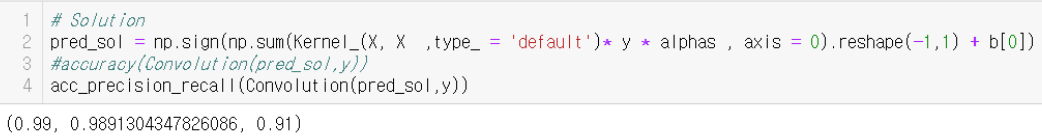

RBF SVM
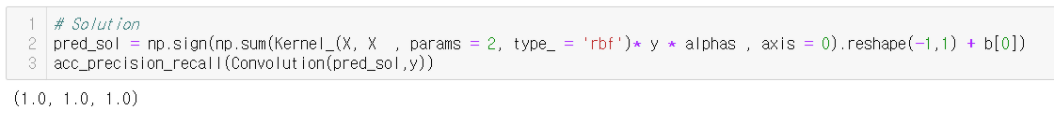

Linear EFSVM
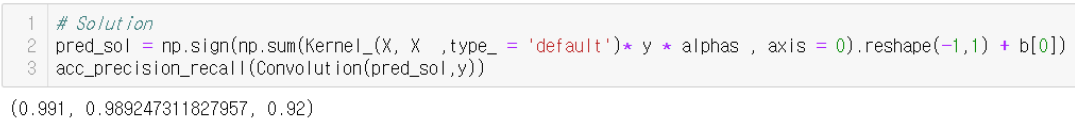

RBF EFSVM
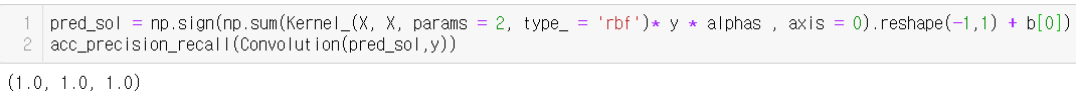

RBF Kernel을 이용한 경우 일반 SVM 에서도 이미 acc,precision,recall 값이 1이 모두 나왔기 때문에
성능 향상은 없었으며 EFSVM의 경우도 같은 결과가 나왔다.

Linear kernel을 이용한 경우 일반 SVM은 (0.99, 0.9891304347... , 0.91)의 결과가 나왔고
EFSVM의 경우 (0.991, 0.98924731..., 0.92)의 결과가 나와서 성능 향상이 있었다.

데이터가 100,900 으로 imbalance하기 때문에
precision과 recall이 중요한 지표이다.

성능 향상은 있었지만 기존의 SVM에서도 minor한 class에 대해서 Precision = 0.0901, reacll = 0.91이 나왔기 때문에
향상된 정도가 미미하게 보일수 있으나

기존의 모델이 precision, recall 에서 성능이 낮았다면 꽤나 큰 성능 향상이 있을 것으로 기대한다.
추후에 SVM과 EFSVM을 비교할 시에는 엔트로피로 인해 추가적으로 발생하는 연산량과 데이터에 따른 모델의 성능을 고려하여 모델을 선택해야 할 것으로 보인다.